In [1]:
import argparse
import glob
import numpy as np
import os
import time
import cv2
import torch
import matplotlib.pyplot as plt
import random
import math
from skimage.metrics import structural_similarity as ssim
from skimage.measure import ransac
from skimage.transform import FundamentalMatrixTransform, AffineTransform
# Suppress the specific warning
import warnings
import csv
import sys
from IPython.utils.capture import capture_output
from datetime import datetime
import pandas as pd

from utils.utils1 import RANSAC_affine_plot, ModelParams

# Stub to warn about opencv version.
if int(cv2.__version__[0]) < 3: # pragma: no cover
  print('Warning: OpenCV 3 is not installed')

# Jet colormap for visualization.
myjet = np.array([[0.        , 0.        , 0.5       ],
                  [0.        , 0.        , 0.99910873],
                  [0.        , 0.37843137, 1.        ],
                  [0.        , 0.83333333, 1.        ],
                  [0.30044276, 1.        , 0.66729918],
                  [0.66729918, 1.        , 0.30044276],
                  [1.        , 0.90123457, 0.        ],
                  [1.        , 0.48002905, 0.        ],
                  [0.99910873, 0.07334786, 0.        ],
                  [0.5       , 0.        , 0.        ]])


# SuperPoint

In [2]:
from utils.SuperPoint import SuperPointFrontend


# Load data

In [4]:
from utils.datagen import datagen

In [17]:
model_params = ModelParams(dataset=args.dataset, sup=args.sup, image=args.image, heatmaps=args.heatmaps, 
                               loss_image=args.loss_image, num_epochs=args.num_epochs, 
                               learning_rate=args.learning_rate, decay_rate=args.decay_rate)
model_params.print_explanation()
train_dataset = datagen(model_params.dataset, True, model_params.sup)
test_dataset = datagen(model_params.dataset, False, model_params.sup)

# Run model

CUDA is available

Row 0: Dataset/synthetic_eye_dataset_test/img_0_original.png, Dataset/synthetic_eye_dataset_test/img_0_transformed_0.png
done sp1
done sp2
Affine_plot
Affine transform matrix from points1 to points2:
(2, 3)
matches1.T[None, :, :]:  (1, 326, 2)
affine_transform1[1]:  (326, 1)
Affine transform matrix from points2 to points1:
[[ 1.00600391e+00 -4.76702348e-02 -2.34746086e+01]
 [ 4.76702348e-02  1.00600391e+00 -6.43972284e+01]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: Since image dtype is floating point, you must specify the data_range parameter. Please read the documentation carefully (including the note). It is recommended that you always specify the data_range anyway.

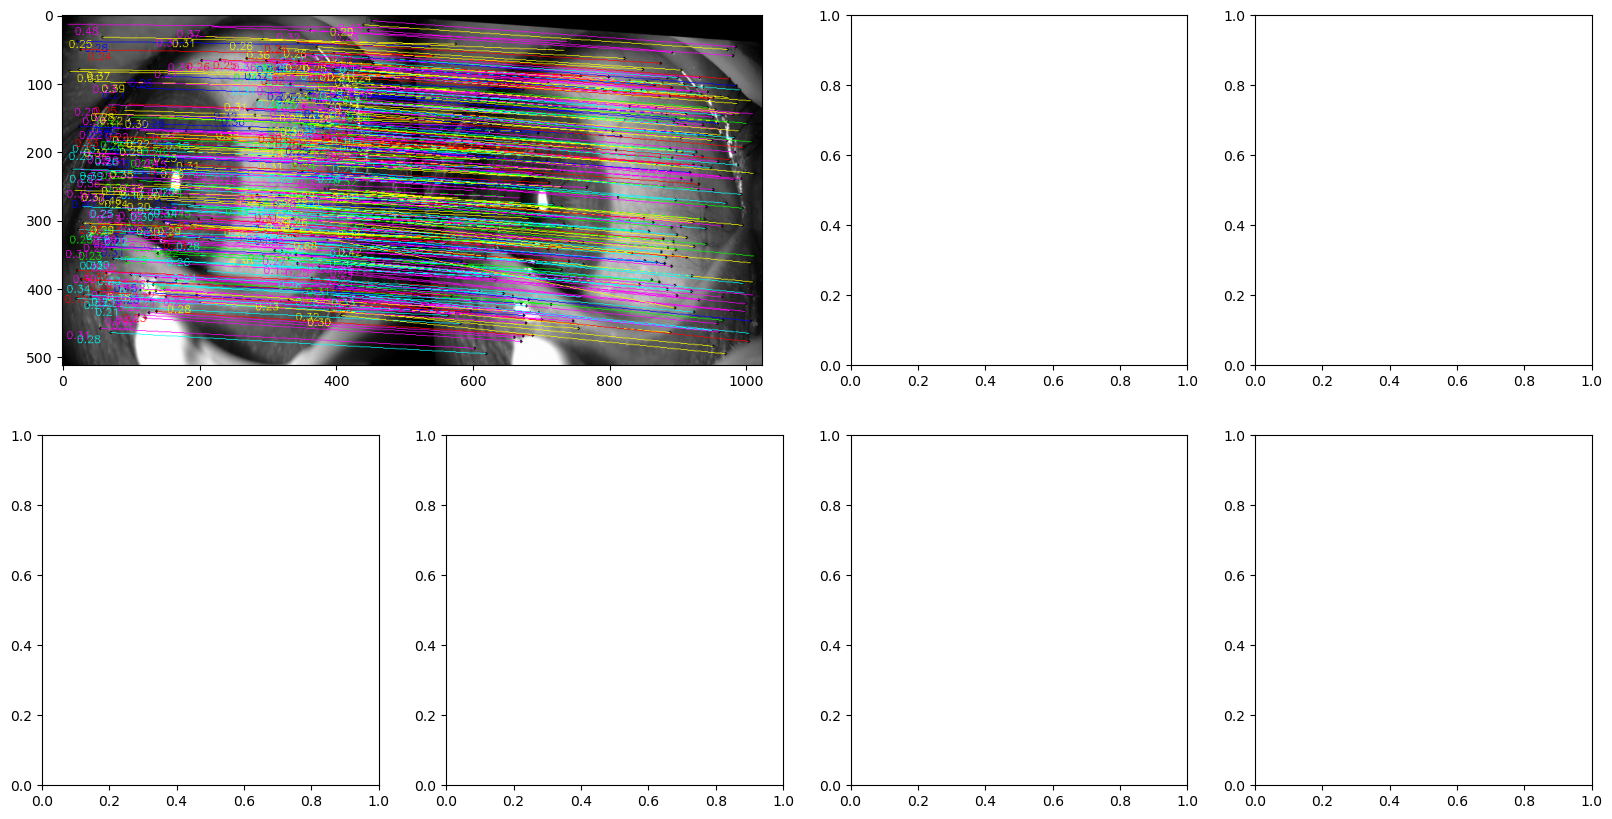

In [18]:
# main function for testing 2 methods and calculate the MSE, TRE, and SSIM
def main_test(weights_path='utils/superpoint_v1.pth', cuda=True, print_output=False):
    # print if cuda is available
    if cuda:
        print('CUDA is available')
    else:
        print('CUDA is not available')

    # Initialize SuperPointFrontend
    superpoint = SuperPointFrontend(weights_path, nms_dist=4,
                          conf_thresh=0.015,
                          nn_thresh=0.7, cuda=cuda)
    
    # list to store image metrics (MSE, SSIM - before and after)
    mse_image_before_list = []
    mse_after12_list = []
    mse_after21_list = []
    mse_after12_RANSAC_list = []
    mse_after21_RANSAC_list = []
    ssim_before_list = []
    ssim_after12_list = []
    ssim_after21_list = []
    ssim_after12_RANSAC_list = []
    ssim_after21_RANSAC_list = []
    
    # create a list to store the MSE, TRE values
    mse_before_list = []
    mse12_list = []
    mse21_list = []
    mse12_RANSAC_list = []
    mse21_RANSAC_list = []
    tre_before_list = []
    tre12_list = []
    tre21_list = []
    tre12_RANSAC_list = []
    tre21_RANSAC_list = []

    # create a dataframe to store the metrics
    df_metrics = pd.DataFrame(columns=['ID', 'Image 1', 'Image 2', 'MSE before', \
            'MSE 1 to 2', 'MSE 2 to 1', 'TRE before', 'TRE 1 to 2', 'TRE 2 to 1', 'MSE before image', 'MSE 1 to 2 image', \
            'MSE 2 to 1 image', 'SSIM before', 'SSIM 1 to 2 image', 'SSIM 2 to 1 image', 'number of points', \
            'MSE 1 to 2 RANSAC', 'MSE 2 to 1 RANSAC', 'TRE 1 to 2 RANSAC', 'TRE 2 to 1 RANSAC', 'MSE 1 to 2 image RANSAC', \
            'MSE 2 to 1 image RANSAC', 'SSIM 1 to 2 image RANSAC', 'SSIM 2 to 1 image RANSAC', 'number of points RANSAC'])
    
    # Save the current sys.stdout
    original_stdout = sys.stdout

    # Create a folder named as yyyy-mm-dd_hh in output_images folder
    dirname = f"../results/{datetime.now().strftime('%Y-%m-%d_%H')+'_eye_synth_test'}"
    os.makedirs(dirname, exist_ok=True)

    # Define a file where you want to save the print statements
    output_file = os.path.join(dirname, 'output.txt')
    # if the file is already there, delete it
    if os.path.exists(output_file):
        os.remove(output_file)
    
    i = 0
    # load images from df_test
    for index, row in df_test.iterrows():
        img1_path = row['source']
        img2_path = row['target']
        # heatmap1_path = os.path.join(img_dir_test, f"{row['imageID'][:-4]}_heatmap.png")
        # heatmap2_path = os.path.join(img_dir_test, f"{row['imageID'][:-4]}_transformed_heatmap.png")
        print(f'\nRow {i}: {img1_path}, {img2_path}')
        image1 = load_image(img1_path)
        image2 = load_image(img2_path)
        # heatmap1 = load_image(heatmap1_path)
        # heatmap2 = load_image(heatmap2_path)

        # Process the first image
        points1, desc1, heatmap1 = superpoint.run(image1)
        print('done sp1')
        # Process the second image
        points2, desc2, heatmap2 = superpoint.run(image2)
        print('done sp2')

        # calculate image similarity before transformation
        mse_image_before_list.append(np.mean((image1 - image2)**2))
        ssim_before_list.append(ssim(image1, image2, data_range=image2.max() - image2.min()))

        if print_output:
            # RANSAC, Affine Transform, Plotting in one function
            number_points, mse_before, mse12, mse21, tre_before, tre12, tre21, mse12_image, mse21_image, ssim12_image, ssim21_image, \
                number_points_RANSAC, mse12_RANSAC, mse21_RANSAC, tre12_RANSAC, tre21_RANSAC, mse12_image_RANSAC, mse21_image_RANSAC, \
                    ssim12_image_RANSAC, ssim21_image_RANSAC = RANSAC_affine_plot(
                    'eye_synth', dirname, i, image1, image2, points1, points2, desc1, desc2, heatmap1, heatmap2, plot=True)

        else:
            try: # need to do this because the warning cannot be suppressed, fix clipping makes the image all black
                # Open the file in append mode to save the print statements
                with open(output_file, 'a') as file:
                    # Redirect sys.stdout to the file
                    sys.stdout = file
                    print(f'Row {i}: {row["Directory"]}, {row["Source image"]}, {row["Target image"]}')

                    # Redirect warnings to the file
                    # warnings.filterwarnings('always')  # Capture all warnings
                    warnings_file = open(output_file, 'a')
                    warnings.showwarning = lambda message, category, filename, lineno, file=warnings_file, line=None: \
                        file.write(warnings.formatwarning(message, category, filename, lineno, line))
                    
                    with capture_output():
                        number_points, mse_before, mse12, mse21, tre_before, tre12, tre21, mse12_image, mse21_image, ssim12_image, ssim21_image, \
                            number_points_RANSAC, mse12_RANSAC, mse21_RANSAC, tre12_RANSAC, tre21_RANSAC, mse12_image_RANSAC, mse21_image_RANSAC, \
                                ssim12_image_RANSAC, ssim21_image_RANSAC = RANSAC_affine_plot(
                                'eye_synth', dirname, i, image1*255., image2*255., points1, points2, desc1, desc2, heatmap1, heatmap2, plot=True)
                    
                    # After the code execution, restore sys.stdout to its original value
                    sys.stdout = original_stdout

                    # Close the warnings file
                    warnings_file.close()

            except Exception as e:
                # Handle exceptions, if any
                print(f"An error occurred: {e}")
        
        # calculate statistics
        mse_before_list.append(mse_before)
        tre_before_list.append(tre_before)
        mse12_list.append(mse12)
        mse21_list.append(mse21)
        tre12_list.append(tre12)
        tre21_list.append(tre21)
        mse_after12_list.append(mse12_image)
        mse_after21_list.append(mse21_image)
        ssim_after12_list.append(ssim12_image)
        ssim_after21_list.append(ssim21_image)
        
        mse12_RANSAC_list.append(mse12_RANSAC)
        mse21_RANSAC_list.append(mse21_RANSAC)
        tre12_RANSAC_list.append(tre12_RANSAC)
        tre21_RANSAC_list.append(tre21_RANSAC)
        mse_after12_RANSAC_list.append(mse12_image_RANSAC)
        mse_after21_RANSAC_list.append(mse21_image_RANSAC)
        ssim_after12_RANSAC_list.append(ssim12_image_RANSAC)
        ssim_after21_RANSAC_list.append(ssim21_image_RANSAC)

        # append the metrics to the dataframe
        df_metrics = pd.concat([df_metrics, pd.DataFrame(data={'ID': i, 'Image 1': row['Source image'], 'Image 2': row['Target image'], \
            'MSE before': mse_before, 'MSE 1 to 2': mse12, 'MSE 2 to 1': mse21, 'TRE before': tre_before, \
            'TRE 1 to 2': tre12, 'TRE 2 to 1': tre21, 'MSE before image': np.mean((image1 - image2)**2), 'MSE 1 to 2 image': mse12_image, \
            'MSE 2 to 1 image': mse21_image, 'SSIM before': ssim(image1, image2), 'SSIM 1 to 2 image': ssim12_image, 'SSIM 2 to 1 image': ssim21_image, \
            'number of points': number_points, 'MSE 1 to 2 RANSAC': mse12_RANSAC, 'MSE 2 to 1 RANSAC': mse21_RANSAC, \
            'TRE 1 to 2 RANSAC': tre12_RANSAC, 'TRE 2 to 1 RANSAC': tre21_RANSAC, 'MSE 1 to 2 image RANSAC': mse12_image_RANSAC, \
            'MSE 2 to 1 image RANSAC': mse21_image_RANSAC, 'SSIM 1 to 2 image RANSAC': ssim12_image_RANSAC, \
            'SSIM 2 to 1 image RANSAC': ssim21_image_RANSAC, 'number of points RANSAC': number_points_RANSAC}, index=[i])])

        i += 1
        if i > 10:
            break

    # print the average MSE
    print('\nNon-RANSAC:')
    print('Landmark points:')
    print(f'Average MSE before transformation: {np.mean(mse_before_list):.4f}')
    print(f'Average MSE for image 1 transformed to image 2: {np.mean(mse12_list):.4f}')
    print(f'Average MSE for image 2 transformed to image 1: {np.mean(mse21_list):.4f}')
    # print the average MSE both ways
    print(f'Average MSE both ways: {np.mean(mse12_list + mse21_list):.4f}')
    # print TRE before transformation
    print(f'Average TRE before transformation: {np.mean(tre_before_list):.4f}')
    # print TRE after transformation
    print(f'Average TRE for image 1 transformed to image 2: {np.mean(tre12_list):.4f}')
    print(f'Average TRE for image 2 transformed to image 1: {np.mean(tre21_list):.4f}')
    # print the average TRE both ways
    print(f'Average TRE both ways: {np.mean(tre12_list + tre21_list):.4f}')

    print('\nImage similarity:')
    print(f'Average MSE before transformation: {np.mean(mse_image_before_list):.4f}')
    print(f'Average MSE for image 1 transformed to image 2: {np.mean(mse_after12_list):.4f}')
    print(f'Average MSE for image 2 transformed to image 1: {np.mean(mse_after21_list):.4f}')
    # print the average MSE both ways
    print(f'Average MSE both ways: {np.mean(mse_after12_list + mse_after21_list):.4f}')
    # print image similarity before transformation
    print(f'Average SSIM before transformation: {np.mean(ssim_before_list):.4f}')
    # print image similarity after transformation
    print(f'Average SSIM for image 1 transformed to image 2: {np.mean(ssim_after12_list):.4f}')
    print(f'Average SSIM for image 2 transformed to image 1: {np.mean(ssim_after21_list):.4f}')
    # print the average SSIM both ways
    print(f'Average SSIM both ways: {np.mean(ssim_after12_list + ssim_after21_list):.4f}')

    print('\nRANSAC:')
    print('Landmark points:')
    print(f'Average MSE before transformation: {np.mean(mse_before_list):.4f}')
    print(f'Average MSE for image 1 transformed to image 2: {np.mean(mse12_RANSAC_list):.4f}')
    print(f'Average MSE for image 2 transformed to image 1: {np.mean(mse21_RANSAC_list):.4f}')
    # print the average MSE both ways
    print(f'Average MSE both ways: {np.mean(mse12_RANSAC_list + mse21_RANSAC_list):.4f}')
    # print TRE before transformation
    print(f'Average TRE before transformation: {np.mean(tre_before_list):.4f}')
    # print TRE after transformation
    print(f'Average TRE for image 1 transformed to image 2: {np.mean(tre12_RANSAC_list):.4f}')
    print(f'Average TRE for image 2 transformed to image 1: {np.mean(tre21_RANSAC_list):.4f}')
    # print the average TRE both ways
    print(f'Average TRE both ways: {np.mean(tre12_RANSAC_list + tre21_RANSAC_list):.4f}')

    print('\nImage similarity:')
    print(f'Average MSE before transformation: {np.mean(mse_image_before_list):.4f}')
    print(f'Average MSE for image 1 transformed to image 2: {np.mean(mse_after12_RANSAC_list):.4f}')
    print(f'Average MSE for image 2 transformed to image 1: {np.mean(mse_after21_RANSAC_list):.4f}')
    # print the average MSE both ways
    print(f'Average MSE both ways: {np.mean(mse_after12_RANSAC_list + mse_after21_RANSAC_list):.4f}')
    # print image similarity before transformation
    print(f'Average SSIM before transformation: {np.mean(ssim_before_list):.4f}')
    # print image similarity after transformation
    print(f'Average SSIM for image 1 transformed to image 2: {np.mean(ssim_after12_RANSAC_list):.4f}')
    print(f'Average SSIM for image 2 transformed to image 1: {np.mean(ssim_after21_RANSAC_list):.4f}')
    # print the average SSIM both ways
    print(f'Average SSIM both ways: {np.mean(ssim_after12_RANSAC_list + ssim_after21_RANSAC_list):.4f}')
    
    # create a new dataframe to store the recently printed metrics
    '''df_metrics = pd.DataFrame(columns=['Image 1', 'Image 2', 'MSE before', \
            'MSE 1 to 2', 'MSE 2 to 1', 'TRE before', 'TRE 1 to 2', 'TRE 2 to 1', 'MSE 1 to 2 image', \
            'MSE 2 to 1 image', 'SSIM 1 to 2 image', 'SSIM 2 to 1 image', 'number of points', \
            'MSE 1 to 2 RANSAC', 'MSE 2 to 1 RANSAC', 'TRE 1 to 2 RANSAC', 'TRE 2 to 1 RANSAC', 'MSE 1 to 2 image RANSAC', \
            'MSE 2 to 1 image RANSAC', 'SSIM 1 to 2 image RANSAC', 'SSIM 2 to 1 image RANSAC', 'number of points RANSAC'])'''

    df_metrics.to_csv('Dataset/metrics_eye_synth_test_RANSAC.csv', index=False)
    print("Done!")
    return df_metrics

df_results = main_test(print_output=True)

# Results

In [ ]:
df_results.head()

,ID,Image 1,Image 2,MSE before,MSE 1 to 2,MSE 2 to 1,TRE before,TRE 1 to 2,TRE 2 to 1,MSE before image,...,number of points,MSE 1 to 2 RANSAC,MSE 2 to 1 RANSAC,TRE 1 to 2 RANSAC,TRE 2 to 1 RANSAC,MSE 1 to 2 image RANSAC,MSE 2 to 1 image RANSAC,SSIM 1 to 2 image RANSAC,SSIM 2 to 1 image RANSAC,number of points RANSAC
0,0,2011248_20161215__L_b2.jpg,2011248_20161215__L_b1.jpg,18.455253,23.976954,24.804339,4.832106,5.099618,5.186906,0.006584,...,257,26.060697,27.497400,5.363270,5.513235,0.014998,0.010098,0.765608,0.794608,69
1,1,2011248_20161215__L_b2.jpg,2011248_20161215__L_b3.jpg,1072.327206,25.933858,26.071969,46.094728,4.748985,4.762649,0.039976,...,272,30.180681,30.803957,5.255644,5.306965,0.025614,0.031617,0.663701,0.678099,82
2,2,2011248_20161215__L_b1.jpg,2011248_20161215__L_b3.jpg,1068.309302,98.296406,97.370198,45.368648,6.261995,6.225104,0.040148,...,215,98.721525,97.449885,6.274373,6.231611,0.016397,0.025205,0.715806,0.705883,75
3,3,01102560_6.jpg,17092560_4.jpg,4956.552632,3352.410466,3311.417327,61.447351,25.286582,25.134395,0.008293,...,19,3345.029266,3314.005876,25.342309,25.224501,0.016437,0.016727,0.751088,0.747513,7
4,4,2477598_20161230__R_b3.jpg,2477598_20161230__R_b1.jpg,830.404494,32.433846,31.295349,40.683349,5.222990,5.130811,0.012404,...,267,32.380441,31.308106,5.220459,5.132803,0.006862,0.005184,0.755432,0.774373,123


Text(0.5, 0, 'SSIM (images)')

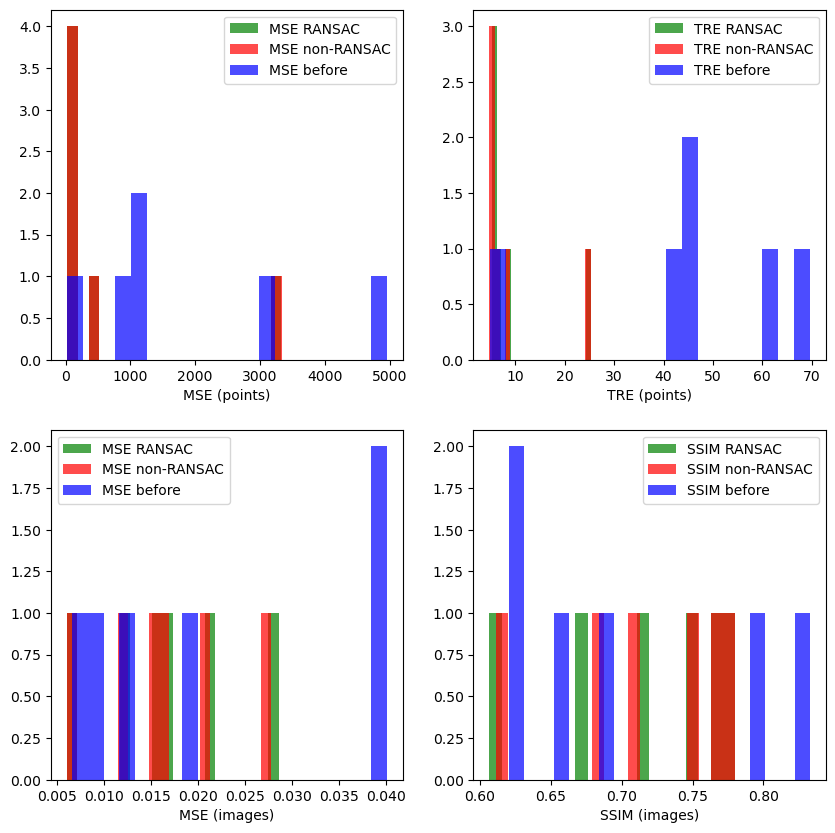

In [ ]:
# plot the histogram of the metrics
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.hist(df_results['MSE before'], bins=20, color='blue', alpha=0.7, label='before')
plt.hist((df_results['MSE 1 to 2 RANSAC']+df_results['MSE 2 to 1 RANSAC'])/2, 
         bins=20, color='green', alpha=0.7, label='RANSAC')
plt.hist((df_results['MSE 1 to 2']+df_results['MSE 2 to 1'])/2, bins=20, color='red', alpha=0.7, label='non-RANSAC')
plt.legend()
plt.xlabel('MSE (points)')

plt.subplot(2, 2, 2)
plt.hist(df_results['TRE before'], bins=20, color='blue', alpha=0.7, label='before')
plt.hist((df_results['TRE 1 to 2 RANSAC']+df_results['TRE 2 to 1 RANSAC'])/2, 
         bins=20, color='green', alpha=0.7, label='RANSAC')
plt.hist((df_results['TRE 1 to 2']+df_results['TRE 2 to 1'])/2, bins=20, color='red', alpha=0.7, label='non-RANSAC')
plt.legend()
plt.xlabel('TRE (points)')

plt.subplot(2, 2, 3)
plt.hist(df_results['MSE before image'], bins=20, color='blue', alpha=0.7, label='before')
plt.hist((df_results['MSE 1 to 2 image RANSAC']+df_results['MSE 2 to 1 image RANSAC'])/2, 
         bins=20, color='green', alpha=0.7, label='RANSAC')
plt.hist((df_results['MSE 1 to 2 image']+df_results['MSE 2 to 1 image'])/2, bins=20, color='red', alpha=0.7, label='non-RANSAC')
plt.legend()
plt.xlabel('MSE (images)')

plt.subplot(2, 2, 4)
plt.hist(df_results['SSIM before'], bins=20, color='blue', alpha=0.7, label='before')
plt.hist((df_results['SSIM 1 to 2 image RANSAC']+df_results['SSIM 2 to 1 image RANSAC'])/2, bins=20, color='green', alpha=0.7, label='RANSAC')
plt.hist((df_results['SSIM 1 to 2 image']+df_results['SSIM 2 to 1 image'])/2, bins=20, color='red', alpha=0.7, label='non-RANSAC')
plt.legend()
plt.xlabel('SSIM (images)')


